# Подготовка окружения и конфигурации

In [1]:
import torch

from utils import train, check_inference, eda

In [2]:
class Config:
    # заморозим рандомайзер
    SEED = 42

    # базовые модели
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    # заморозка слоев наследуемых моделей
    IMAGE_MODEL_UNFREEZE = ""

    NUM_INGR = "" # посчитаем при инициализации обучающего датасета
    EMB_INGR = 32

    MASS_MEAN = ""  # посчитаем при инициализации обучающего датасета
    MASS_STD = ""  # посчитаем при инициализации обучающего датасета
    
    # гиперпараметры
    BATCH_SIZE = 64
    EMB_INGR_LR = 1e-3
    CLASSIFIER_LR = 1e-3
    EPOCHS = 45
    DROPOUT = 0.5 # было 0.3
    HUBER_DELTA=30.0
    WEIGHT_DECAY=5e-4

    # файлы
    DF_PATH = "data/dish.csv"
    IMG_PATH = "data/images/"
    SAVE_PATH = "best_model.pth"

cfg = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device: ', device)

device:  cuda


# Изучение объектов данных тестового сета

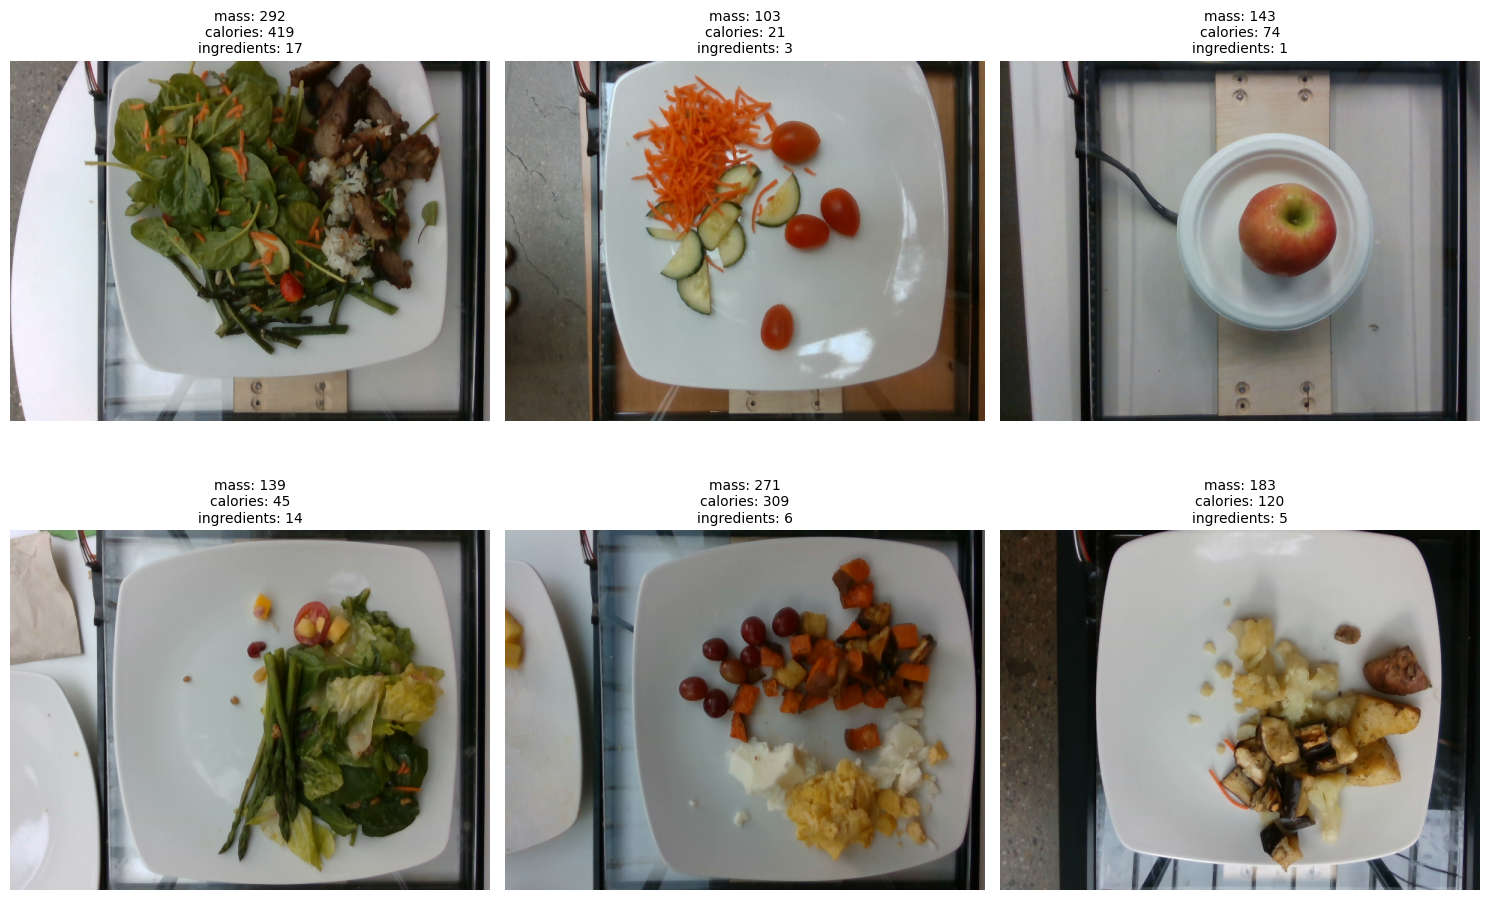

unique ingredients in train: 198
mean ingredients in dish: 7.4


In [3]:
eda(cfg)

## Выводы

1. Преимущественно белый фон фотографий. Блюда разложены не строго по центру, есть повороты как тарелок, так и блюд, есть смещения за край кадра
2. Картинки весьма пестрые особенно при наличии большого количества ингредиентов блюда
3. Большой разброс количества ингредиентов даже на малой выборке от 1 до 17
4. Больше количество уникальных ингредиентов в целом по сету и небольшое в среднем на блюдо

## Идеи на разработку

**картинка**
1. Возьмем сверточную модель без головы, попробуем обойтись без ее тюнинга
2. Добавим в обучающий датасет агументаций на флипы, повороты, оттенки цветов и контрастность

**ингредиенты**
1. Попробуем обойтись без отражения состава в язык и привлечения языковых моделей
2. Токенизируем коды ингрединтов в натуральные индексы, добавим паддинг на те коды, что не встретились в трейне
3. Натрениуем эмбеддинг в размерность 32 для добавления вектора ингредиентов в модель

**масса**
1. Каллорийность блюда (одного и того же в смысле состава и фото) растет пропорционально его массе, поэтому не будем делать со скаляром массы никаких преобразований, кроме нормализации на статистику тренировочного датасета

**мультимодальность**
1. Конкатенируем вектор картиники, суммовой ембеддинг ингредиентов и скаляр норнмализованной массы

**регрессор**
1. Сделаем три слоя со снижением размерности ->256->64->1
2. Активация RELU, добавим Dropout-ы для контроля переобучения

**итого**
1. Тренируем эмбеддинг ингредиентов и голову-регрессор
2. Используем pretrained-модель для векторизации картинок
2. Используем Huber-loss, как вариацию MAE

# Аугментация изображений

### Посмотрим на аугментированные предложенным подходом изображения блюд

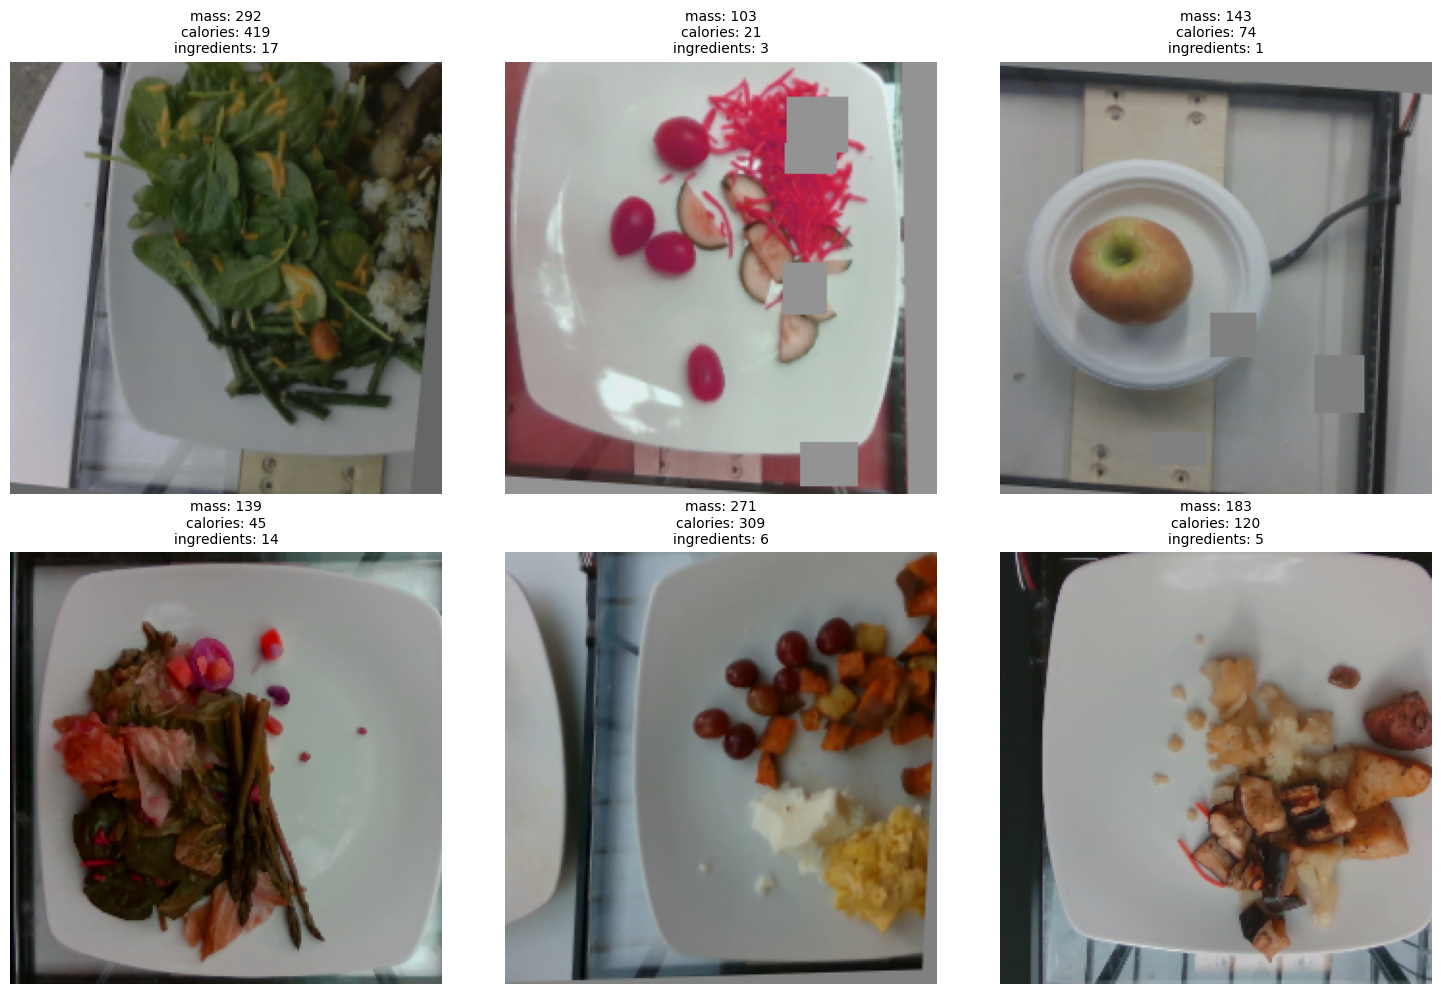

In [4]:
eda(cfg, augmented=True)

# Обучение модели

params to train: 367,457


  val epoch 1  : 100%|██████████| 8/8 [00:21<00:00,  2.73s/it, last batch loss=4500.4, last batch mae=164.0]


total epoch 1   train loss 6705.7, val loss 5872.3 train mae 237.9, val mae 209.7
----------------------------------------
New best model, epoch: 1
----------------------------------------


  val epoch 2  : 100%|██████████| 8/8 [00:13<00:00,  1.70s/it, last batch loss=2822.2, last batch mae=107.5]


total epoch 2   train loss 4556.6, val loss 4095.7 train mae 166.1, val mae 150.6
----------------------------------------
New best model, epoch: 2
----------------------------------------


  val epoch 3  : 100%|██████████| 8/8 [00:13<00:00,  1.70s/it, last batch loss=2233.5, last batch mae=88.1] 


total epoch 3   train loss 3574.4, val loss 3596.0 train mae 133.2, val mae 133.6
----------------------------------------
New best model, epoch: 3
----------------------------------------


  val epoch 4  : 100%|██████████| 8/8 [00:15<00:00,  1.92s/it, last batch loss=2135.1, last batch mae=84.7] 


total epoch 4   train loss 3194.2, val loss 3163.1 train mae 120.2, val mae 119.3
----------------------------------------
New best model, epoch: 4
----------------------------------------


  val epoch 5  : 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, last batch loss=2155.0, last batch mae=86.1] 


total epoch 5   train loss 2878.7, val loss 2872.6 train mae 109.5, val mae 109.8
----------------------------------------
New best model, epoch: 5
----------------------------------------


  val epoch 6  : 100%|██████████| 8/8 [00:13<00:00,  1.73s/it, last batch loss=1788.0, last batch mae=72.4] 


total epoch 6   train loss 2689.7, val loss 2550.5 train mae 103.1, val mae 98.3
----------------------------------------
New best model, epoch: 6
----------------------------------------


  val epoch 7  : 100%|██████████| 8/8 [00:13<00:00,  1.64s/it, last batch loss=1764.5, last batch mae=72.3] 


total epoch 7   train loss 2514.8, val loss 2367.7 train mae 97.1, val mae 92.1
----------------------------------------
New best model, epoch: 7
----------------------------------------


  val epoch 8  : 100%|██████████| 8/8 [00:16<00:00,  2.12s/it, last batch loss=1734.4, last batch mae=70.9] 


total epoch 8   train loss 2319.7, val loss 2247.9 train mae 90.4, val mae 87.9
----------------------------------------
New best model, epoch: 8
----------------------------------------


  val epoch 9  : 100%|██████████| 8/8 [00:13<00:00,  1.74s/it, last batch loss=1493.2, last batch mae=62.3] 


total epoch 9   train loss 2239.9, val loss 2171.6 train mae 87.8, val mae 85.4
----------------------------------------
New best model, epoch: 9
----------------------------------------



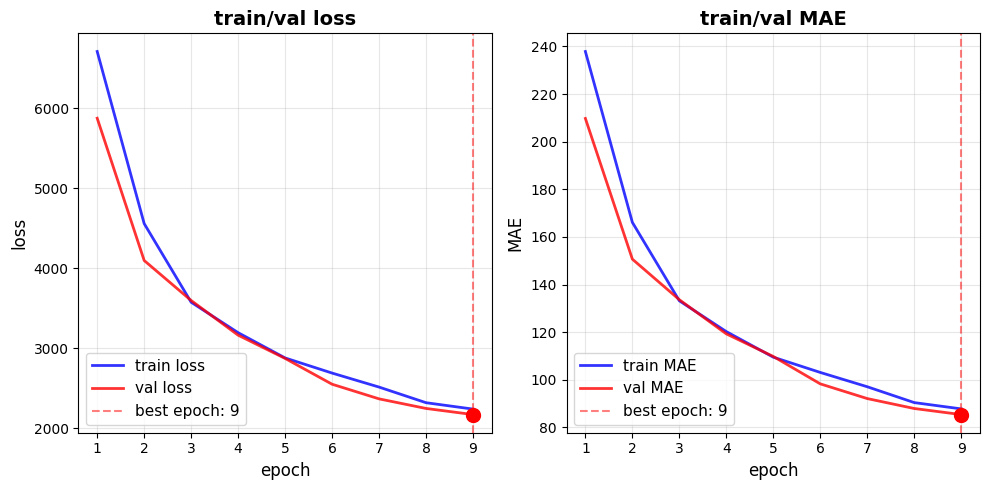


stat:
final train loss: 2239.9
final val loss:   2171.6
final train MAE:  87.8
final val MAE:    85.4

best val loss:  2171.6 (epoch 9)
best val MAE:     85.4 (epoch 9)



  val epoch 10 : 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, last batch loss=1605.1, last batch mae=66.7] 


total epoch 10  train loss 2131.6, val loss 2101.9 train mae 84.1, val mae 83.1
----------------------------------------
New best model, epoch: 10
----------------------------------------


  val epoch 11 : 100%|██████████| 8/8 [00:13<00:00,  1.71s/it, last batch loss=1492.8, last batch mae=62.1]


total epoch 11  train loss 2139.3, val loss 2020.7 train mae 84.2, val mae 80.0
----------------------------------------
New best model, epoch: 11
----------------------------------------


  val epoch 12 : 100%|██████████| 8/8 [00:13<00:00,  1.69s/it, last batch loss=1267.8, last batch mae=54.8]


total epoch 12  train loss 1985.0, val loss 1902.4 train mae 79.0, val mae 75.9
----------------------------------------
New best model, epoch: 12
----------------------------------------


  val epoch 13 : 100%|██████████| 8/8 [00:16<00:00,  2.03s/it, last batch loss=1345.3, last batch mae=57.4]


total epoch 13  train loss 1936.0, val loss 1800.1 train mae 77.4, val mae 72.4
----------------------------------------
New best model, epoch: 13
----------------------------------------


  val epoch 14 : 100%|██████████| 8/8 [00:13<00:00,  1.69s/it, last batch loss=1225.2, last batch mae=53.0]


total epoch 14  train loss 1902.2, val loss 1780.3 train mae 76.1, val mae 71.8
----------------------------------------
New best model, epoch: 14
----------------------------------------


  val epoch 15 : 100%|██████████| 8/8 [00:13<00:00,  1.69s/it, last batch loss=1317.0, last batch mae=56.4]


total epoch 15  train loss 1819.0, val loss 1696.9 train mae 73.2, val mae 68.8
----------------------------------------
New best model, epoch: 15
----------------------------------------


  val epoch 16 : 100%|██████████| 8/8 [00:15<00:00,  1.93s/it, last batch loss=1187.5, last batch mae=51.2]


total epoch 16  train loss 1784.9, val loss 1621.0 train mae 72.0, val mae 65.9
----------------------------------------
New best model, epoch: 16
----------------------------------------


  val epoch 17 : 100%|██████████| 8/8 [00:13<00:00,  1.68s/it, last batch loss=1276.8, last batch mae=54.6]


total epoch 17  train loss 1752.5, val loss 1638.5 train mae 70.8, val mae 66.7
----------------------------------------


  val epoch 18 : 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, last batch loss=1096.0, last batch mae=48.4]


total epoch 18  train loss 1697.8, val loss 1537.4 train mae 69.0, val mae 63.2
----------------------------------------
New best model, epoch: 18
----------------------------------------



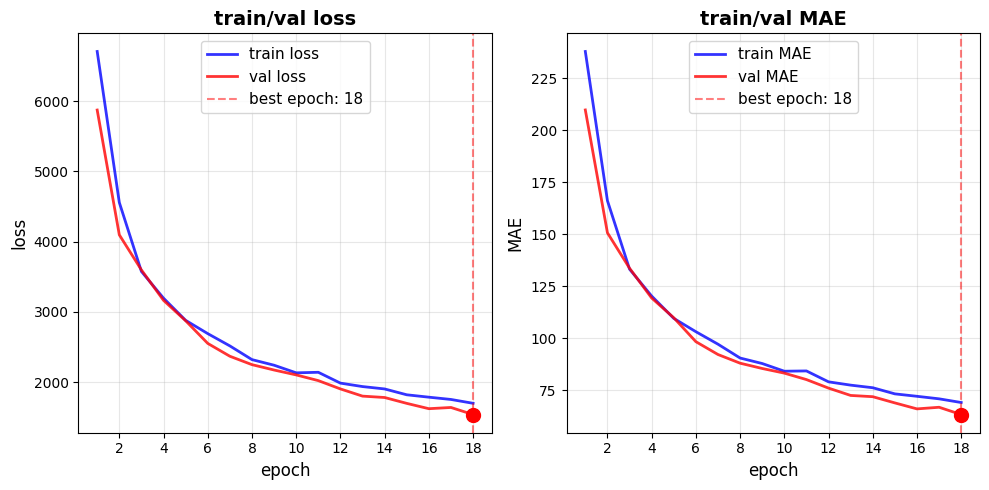


stat:
final train loss: 1697.8
final val loss:   1537.4
final train MAE:  69.0
final val MAE:    63.2

best val loss:  1537.4 (epoch 18)
best val MAE:     63.2 (epoch 18)



  val epoch 19 : 100%|██████████| 8/8 [00:17<00:00,  2.17s/it, last batch loss=1073.2, last batch mae=47.4]


total epoch 19  train loss 1660.2, val loss 1501.9 train mae 67.8, val mae 61.9
----------------------------------------
New best model, epoch: 19
----------------------------------------


  val epoch 20 : 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, last batch loss=1074.1, last batch mae=46.7]


total epoch 20  train loss 1592.5, val loss 1463.9 train mae 65.4, val mae 60.7
----------------------------------------
New best model, epoch: 20
----------------------------------------


  val epoch 21 : 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, last batch loss=1050.3, last batch mae=46.2]


total epoch 21  train loss 1536.1, val loss 1431.3 train mae 63.4, val mae 59.4
----------------------------------------
New best model, epoch: 21
----------------------------------------


  val epoch 22 : 100%|██████████| 8/8 [00:14<00:00,  1.85s/it, last batch loss=1080.1, last batch mae=47.8]


total epoch 22  train loss 1625.3, val loss 1373.5 train mae 66.5, val mae 57.6
----------------------------------------
New best model, epoch: 22
----------------------------------------


  val epoch 23 : 100%|██████████| 8/8 [00:14<00:00,  1.81s/it, last batch loss=1000.5, last batch mae=43.9]


total epoch 23  train loss 1508.4, val loss 1384.0 train mae 62.5, val mae 57.6
----------------------------------------
New best model, epoch: 23
----------------------------------------


  val epoch 24 : 100%|██████████| 8/8 [00:15<00:00,  1.93s/it, last batch loss=978.7, last batch mae=44.0] 


total epoch 24  train loss 1583.9, val loss 1447.2 train mae 65.0, val mae 60.1
----------------------------------------


  val epoch 25 : 100%|██████████| 8/8 [00:13<00:00,  1.74s/it, last batch loss=1041.0, last batch mae=46.3]


total epoch 25  train loss 1568.0, val loss 1384.8 train mae 64.5, val mae 57.8
----------------------------------------


  val epoch 26 : 100%|██████████| 8/8 [00:16<00:00,  2.03s/it, last batch loss=997.3, last batch mae=44.5] 


total epoch 26  train loss 1536.0, val loss 1330.2 train mae 63.4, val mae 56.0
----------------------------------------
New best model, epoch: 26
----------------------------------------


  val epoch 27 : 100%|██████████| 8/8 [00:14<00:00,  1.82s/it, last batch loss=983.4, last batch mae=44.3] 


total epoch 27  train loss 1484.4, val loss 1370.0 train mae 61.6, val mae 57.2
----------------------------------------



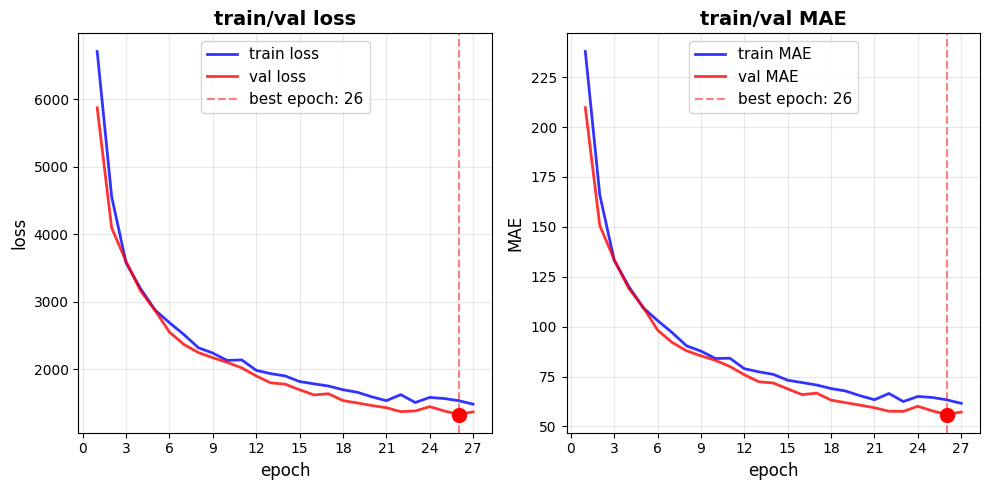


stat:
final train loss: 1484.4
final val loss:   1370.0
final train MAE:  61.6
final val MAE:    57.2

best val loss:  1330.2 (epoch 26)
best val MAE:     56.0 (epoch 26)



  val epoch 28 : 100%|██████████| 8/8 [00:14<00:00,  1.77s/it, last batch loss=952.5, last batch mae=43.1] 


total epoch 28  train loss 1491.3, val loss 1331.0 train mae 61.8, val mae 55.9
----------------------------------------
New best model, epoch: 28
----------------------------------------


  val epoch 29 : 100%|██████████| 8/8 [00:13<00:00,  1.73s/it, last batch loss=907.7, last batch mae=41.2] 


total epoch 29  train loss 1458.9, val loss 1336.2 train mae 60.9, val mae 56.1
----------------------------------------


  val epoch 30 : 100%|██████████| 8/8 [00:14<00:00,  1.85s/it, last batch loss=887.6, last batch mae=40.6] 


total epoch 30  train loss 1427.0, val loss 1322.5 train mae 59.7, val mae 55.5
----------------------------------------
New best model, epoch: 30
----------------------------------------


  val epoch 31 : 100%|██████████| 8/8 [00:14<00:00,  1.82s/it, last batch loss=861.9, last batch mae=39.8] 


total epoch 31  train loss 1498.8, val loss 1338.0 train mae 62.1, val mae 56.0
----------------------------------------


  val epoch 32 : 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, last batch loss=865.6, last batch mae=39.9] 


total epoch 32  train loss 1450.5, val loss 1326.1 train mae 60.4, val mae 55.6
----------------------------------------


  val epoch 33 : 100%|██████████| 8/8 [00:13<00:00,  1.70s/it, last batch loss=823.2, last batch mae=38.4] 


total epoch 33  train loss 1377.7, val loss 1313.1 train mae 57.9, val mae 55.3
----------------------------------------
New best model, epoch: 33
----------------------------------------


  val epoch 34 : 100%|██████████| 8/8 [00:12<00:00,  1.62s/it, last batch loss=859.9, last batch mae=39.8] 


total epoch 34  train loss 1420.2, val loss 1324.0 train mae 59.3, val mae 55.5
----------------------------------------


  val epoch 35 : 100%|██████████| 8/8 [00:13<00:00,  1.71s/it, last batch loss=877.1, last batch mae=39.9] 


total epoch 35  train loss 1415.8, val loss 1318.1 train mae 59.3, val mae 55.2
----------------------------------------
New best model, epoch: 35
----------------------------------------


  val epoch 36 : 100%|██████████| 8/8 [00:12<00:00,  1.61s/it, last batch loss=804.9, last batch mae=37.9] 


total epoch 36  train loss 1378.9, val loss 1278.1 train mae 57.9, val mae 54.0
----------------------------------------
New best model, epoch: 36
----------------------------------------



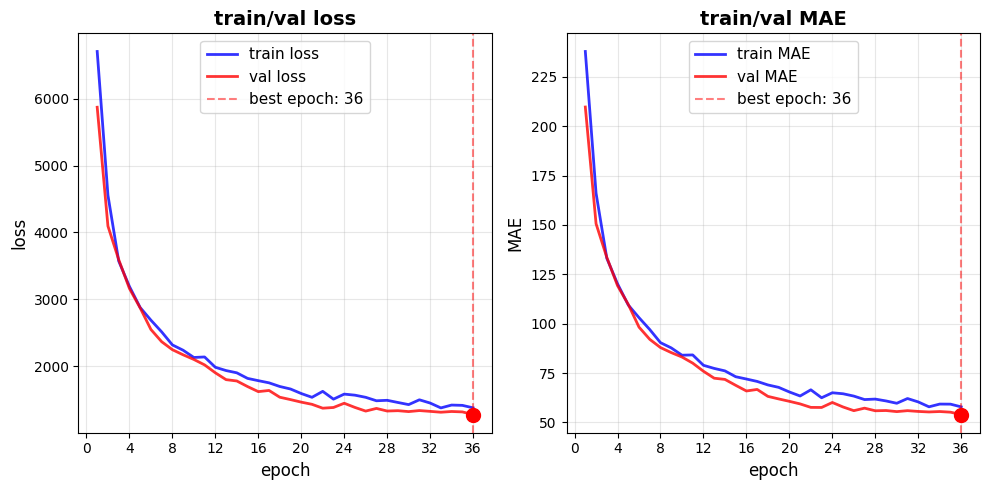


stat:
final train loss: 1378.9
final val loss:   1278.1
final train MAE:  57.9
final val MAE:    54.0

best val loss:  1278.1 (epoch 36)
best val MAE:     54.0 (epoch 36)



  val epoch 37 : 100%|██████████| 8/8 [00:13<00:00,  1.63s/it, last batch loss=782.4, last batch mae=36.8] 


total epoch 37  train loss 1386.0, val loss 1244.6 train mae 58.1, val mae 52.8
----------------------------------------
New best model, epoch: 37
----------------------------------------


  val epoch 38 : 100%|██████████| 8/8 [00:12<00:00,  1.60s/it, last batch loss=806.9, last batch mae=37.4] 


total epoch 38  train loss 1446.4, val loss 1279.7 train mae 60.3, val mae 54.1
----------------------------------------


  val epoch 39 : 100%|██████████| 8/8 [00:12<00:00,  1.60s/it, last batch loss=766.7, last batch mae=36.3] 


total epoch 39  train loss 1388.7, val loss 1264.7 train mae 58.2, val mae 53.5
----------------------------------------


  val epoch 40 : 100%|██████████| 8/8 [00:12<00:00,  1.60s/it, last batch loss=815.6, last batch mae=38.3] 


total epoch 40  train loss 1339.8, val loss 1259.3 train mae 56.6, val mae 53.4
----------------------------------------


  val epoch 41 : 100%|██████████| 8/8 [00:12<00:00,  1.60s/it, last batch loss=825.1, last batch mae=38.5] 


total epoch 41  train loss 1362.7, val loss 1219.4 train mae 57.3, val mae 52.0
----------------------------------------
New best model, epoch: 41
----------------------------------------


  val epoch 42 : 100%|██████████| 8/8 [00:12<00:00,  1.61s/it, last batch loss=824.6, last batch mae=38.0] 


total epoch 42  train loss 1428.8, val loss 1191.1 train mae 59.6, val mae 50.9
----------------------------------------
New best model, epoch: 42
----------------------------------------


  val epoch 43 : 100%|██████████| 8/8 [00:12<00:00,  1.61s/it, last batch loss=810.5, last batch mae=37.9] 


total epoch 43  train loss 1299.2, val loss 1245.7 train mae 55.1, val mae 52.9
----------------------------------------


  val epoch 44 : 100%|██████████| 8/8 [00:12<00:00,  1.61s/it, last batch loss=826.7, last batch mae=38.5] 


total epoch 44  train loss 1371.7, val loss 1231.5 train mae 57.8, val mae 52.5
----------------------------------------


  val epoch 45 : 100%|██████████| 8/8 [00:12<00:00,  1.60s/it, last batch loss=730.3, last batch mae=34.2] 


total epoch 45  train loss 1320.2, val loss 1180.3 train mae 55.8, val mae 50.6
----------------------------------------
New best model, epoch: 45
----------------------------------------



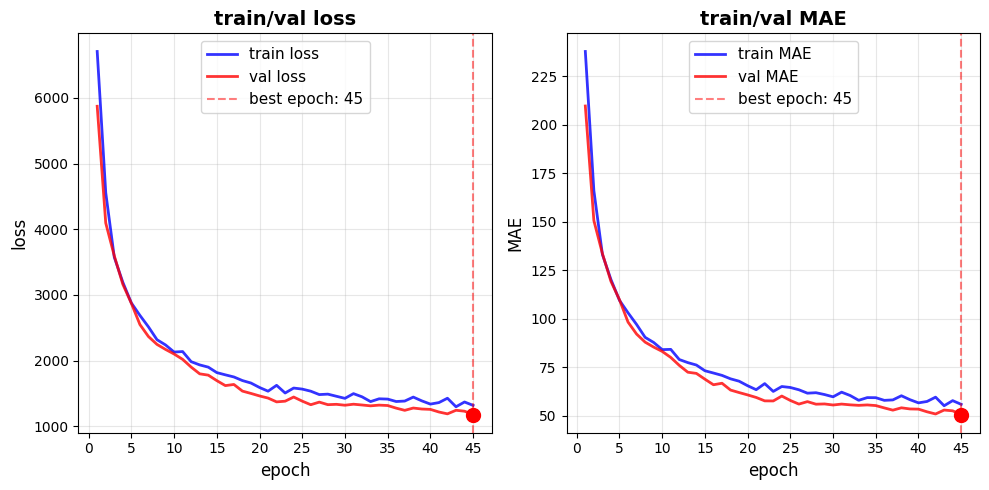


stat:
final train loss: 1320.2
final val loss:   1180.3
final train MAE:  55.8
final val MAE:    50.6

best val loss:  1180.3 (epoch 45)
best val MAE:     50.6 (epoch 45)



In [5]:
train_loss_stat, val_loss_stat, train_mae_stat, val_mae_stat = train(cfg, device)

## Выводы

1. Обучились до требуемой MAE за 45 эпох и ~ 1,5 мин на эпоху
2. После 20-й эпохи наметилось некоторое переобучение, возможно имело смысл работать c Dropout ближе к 0.5
3. Модель медленно сходится на поздних эпохах, возможно будет уместно применить ReduceOnPlato

# Инференс лучшей модели

val MAE: 50.6


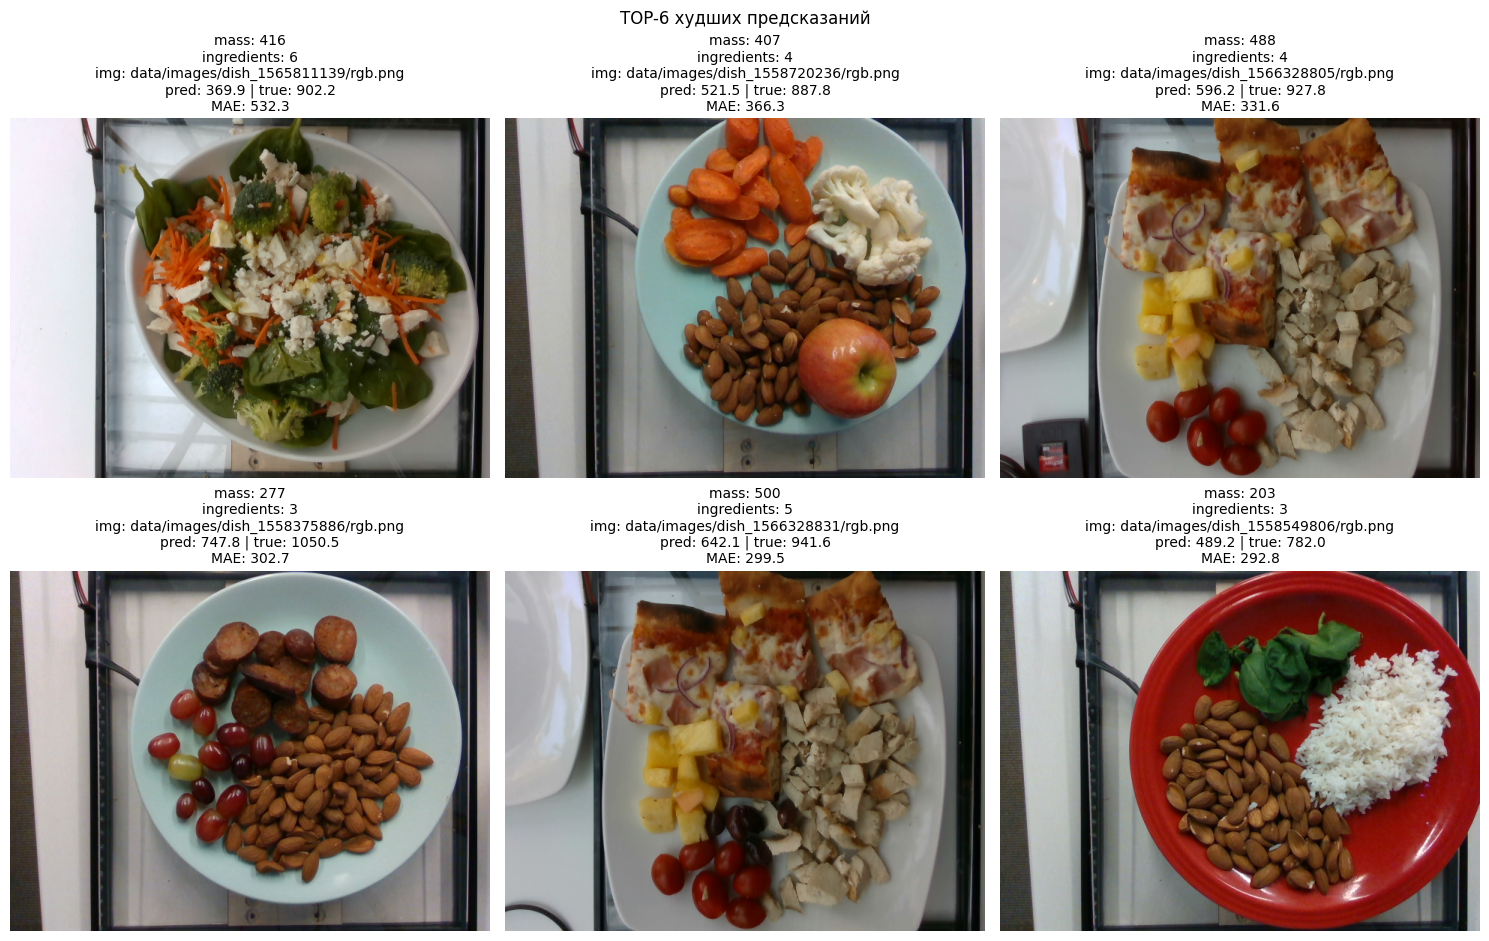

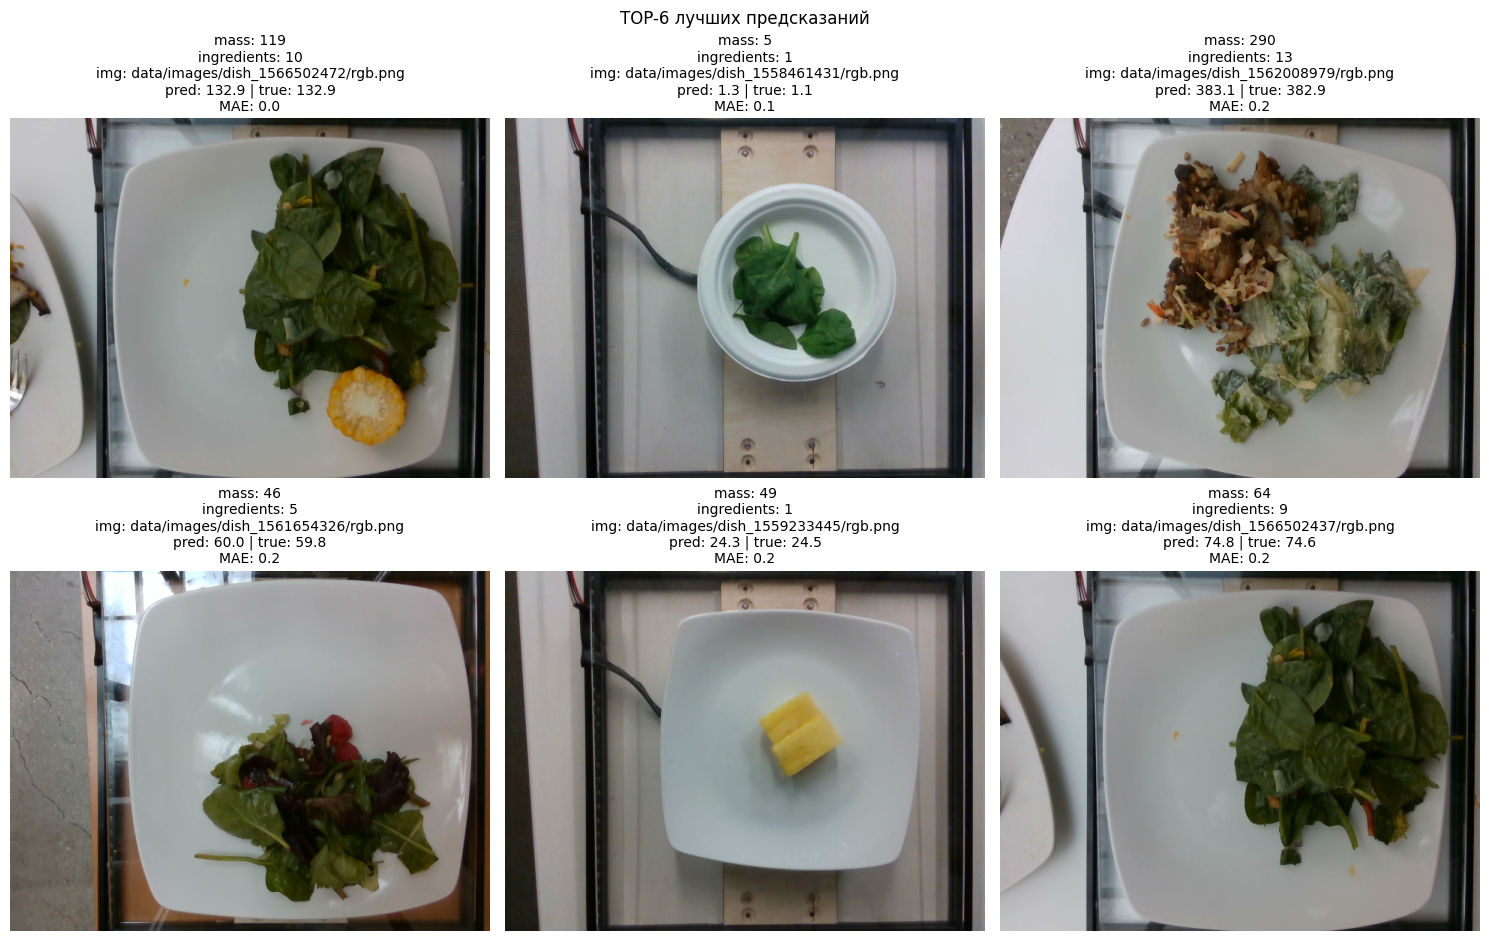

In [6]:
df = check_inference(cfg, device)

## Выводы

**Худшие предсказания**
1. Модель явно не разобралась в высокой калорийности орехов, возможно их было мало в трейне, или она не отличила их от чего то детического.
2. На картинках количество ингредиентов - тех, что встречались в обучающей выборке (как следствие есть блюда с 0 ингридентов). Если модель не получает информации об ингредиентах, они чересчур копозитны и их мало на сложное блюдо (ингредиент - салат из тунца - редкий и сложный), модель ошибается. Можем сделать вывод, что состав - важный для нее признак.
3. Так же среди худших по предсказаниями - блюда с обилием цветов, видимо модель не смогла их обобщить

**Лучшие предсказания**
1. Модель хорошо сориентировалась с небольшиими по фактическому составу компонентов блюдами
2. Так же, обратим внимание на то, что в топе блюда с хорошо различимыми на картинке деталями

**Предложения по улучшению**
1. Разморозить последние сверточные слои модели, работающей с картинками, - многие мелко нарубленные блюда с виду вряд ли похожи на что-то, что она видела на обучении.
2. Поработать с дисбалансом ингридентов (случай с орехами), возможно - дополнить датасет аугментированными данными с ними.
3. Добавить эпох обучению, предварительно поработав с наметившимся переобучением.